<h1>Audio Signal Processing</h1>

<p>    In this project I want to explore Signal Processing, which is a crucial field in the development of heart-monitoring technology in the medical field, conservation efforts, and of course, their more general uses of speech recognition and music classification.  As music is one of my passions, I would like to focus on that in this project.  I was inspired by a certain form of media most common on the Japanese media known as Oto-MADs, which are stitched-together remixes of a popular song using voice clips from unrelated media.  It was then that I wanted to know whether I could recreate one of my favorite songs using only parts of an 6-second audio clip of a man hitting his head on a washing machine.  In order to do that "perfectly", I would need to know how to manipulate those 11 seconds to their fullest potential.</p>
<p>While I don't exactly know how to achieve that through code at present, I figured that I would at least start by making something that I could use to identify and classify audio clips, and that was what this project turned out to be about.  My dataset for this project consists of percussive samples that I have downloaded from Cymatics.fm, and much of the theoretical part of signal processing I learned came from lessons from <a href='https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0'>Valerio Velardo's YouTube channel</a> and the application part, from studying other Signal Processing projects, such as <a href='https://github.com/IliaZenkov/sklearn-audio-classification/blob/master/sklearn_audio_classification.ipynb'>Ilia Zenkov's audio classification project</a>.</p>

<h3>Libraries</h3>
<p>In addition to the normal libraries used in data science, librosa is added to this list as it contains a lot of the tools needed to extract the features for audio processing (it also makes things easier since I wouldn't have to implement them from scratch).</p>

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile

<h3>Features</h3>
<p>The SignalData class is divided into 4 sections (other than the constructor): the time-domain features, the frequency-domain features, plotting, and assembling features to be used in machine learning.</p>

In [2]:
class SignalData:
    
    def __init__(self, filename, sr_=None, FS=512, HL=256):
        '''
        Descriptions of Attributes:
        .filename: string of filename
        .signal: extracted signals from librosa
        .FS: frame size
        .HL: hop length
        .sr: sample rate, sample rate of wav file set by default
        .nyquist: nyquist frequency = maximum measurable frequency given the sample rate
        .size: # of samples 
        '''
        self.filename = filename
        #frame size and hop length are necessary for many processing functions to work:
        #frame size is the size of the interval it processes at once
        #hop length is the amount the interval shifts for the next frame to be processed
        #the frames overlap to prevent spectral leakage.
        self.FS = FS
        self.HL = HL
        #get signal data and sample rate (if unspecified)
        self.signal, self.sr = librosa.load(filename, sr=sr_)
        
        #In order to deal with audio clips of different sizes, padding with zeroes is imperative
        if len(self.signal)/self.sr < 30:
            np.pad(self.signal, (0, 30*self.sr - len(self.signal)), 'constant')
        self.spectrogram = librosa.stft(self.signal, n_fft=self.FS, hop_length=self.HL)
        self.nyquist = self.sr/2
        self.size = self.signal.size
        self.duration = self.size * len(self.signal)
        
    #FEATURES
    
    #TIME DOMAIN FEATURES
    #I could have included these in the constructor, but I wanted to show the time-domain features separately
    def amp_env(self):
        '''
        Input: signal array, frame size (in samples), hop length (in samples)
        Output: amplitude envelope = array of maximum amplitudes of each frame (upper bounds of signal energy)
        
        '''
    
        envelope = [max(self.signal[i:i + self.FS])for i in range(0, len(self.signal), self.HL)]
        return np.array(envelope)
    
    def rms(self):
        '''
        Input: frame size (in samples), hop length (in samples)
        Output: root mean square energy per frame

        '''
        return librosa.feature.rms(y=self.signal, frame_length=self.FS, hop_length=self.HL)
    
    def zcr(self):
        '''
        Input: frame size (in samples), hop length (in samples)
        Output: Zero crossing rate of the audio per sample
        
        Note: can be helpful in distinguishing percussive samples
        '''
        return librosa.feature.zero_crossing_rate(self.signal, frame_length=self.FS, hop_length=self.HL)
    
    
        
    #FREQUENCY DOMAIN FEATURES
    def mel_gram(self, mel_bands):
        '''
        Generates the mel spectrogram data given the number of mel bands (filters).  Converting a spectrogram
        to mels makes it more relevant to the human perception.
        '''
        return librosa.feature.melspectrogram(y=self.signal, sr=self.sr, n_fft=self.FS, 
                                                  hop_length=self.HL, n_mels=mel_bands)
    
    def mfcc_features(self, n_coeffs):
        '''
        Input: Number of mel-frequency cepstrum coefficients (descriptors of timbre)
        Output: (MFCCS, deriv1, deriv2)
        
        The most important feature for this project
        '''
        mfccs = librosa.feature.mfcc(y=self.signal, n_mfcc=n_coeffs, sr=self.sr)
        delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
        delta2_mfccs = librosa.feature.delta(delta_mfccs, mode='nearest')
        return (mfccs, delta_mfccs, delta2_mfccs)
    
        
    
    def fft_data(self):
        '''
        returns a tuple of the extracted fast fourier transform data with the magnitudes (may remove later for brevity)
        '''
        fourier = sp.fft.fft(self.signal)
        mag = np.absolute(fourier)
        return (fourier, mag)
    
    def spectral_centroid(self):
        '''
        returns the weighted means of the frequencies in the spectrogram at a certain points in time
        '''
        return librosa.feature.spectral_centroid(y=self.signal, sr=self.sr, n_fft=self.FS, hop_length=self.HL)
    
    def bandwidth(self):
        '''
        returns the spread of the energy from the spectral centroid at points in time
        '''
        return librosa.feature.spectral_bandwidth(y=self.signal, sr=self.sr, n_fft=self.FS, hop_length=self.HL)
    
    def band_energy_ratio(self, div_freq):
        '''
        returns the ratio of the energy in the frequencies below the threshold frequency to the energy
        above it.  It becomes very useful in determining genre and identifying different abstract parts of a song.
        This proved to be not that useful for this particular project, but it was nice to have.
        '''
        #Get split frequencies
        #shape of the spectrogram = (# of frequency bins, time)
        freq_gap = self.nyquist / self.spectrogram.shape[0]
        divider_bin = int(np.floor(div_freq / freq_gap))
        
        #Calculate BER

        power_spectrogram = np.abs(self.spectrogram) ** 2
        #transpose to get (time, frequency bins) to iterate through the list of frequency bins at each time frame
        power_spectrogram = power_spectrogram.T
        BERs = np.array([np.sum(frame[:divider_bin])/np.sum(frame[divider_bin:]) for frame in power_spectrogram])
        BERs[BERs == np.inf] = np.nan
        BERs = np.nan_to_num(BERs)
        
        return BERs 
    
    #visualizations
    
    def plot_BER(self, div_freq):
        '''
        Plot the Band Energy Ratio over time
        '''
        plt.figure()
        data = self.band_energy_ratio(div_freq)
        t = librosa.frames_to_time(range(data.size), hop_length=self.HL)
        plt.plot(t, data, color='b')
        plt.title(f'Band Energy Ratio of {self.filename}')
        plt.show()
    
    def plot_zcr(self):
        '''
        Plot the ZCR over time
        '''
        plt.figure()
        zcr = self.zcr()
        t_zcr = librosa.frames_to_time(range(zcr.size), hop_length=self.HL)
        plt.plot(t_zcr, zcr[0], color='r')
        plt.title(f'Zero Crossing Rate of {self.filename}')
        plt.show()
    
    def visualize_mfccs(self, n_coeffs):
        '''
        Visualize the MFCCs, or Mel-Frequency Cepstrum Coefficients, crucial for distinguishing timbre.
        '''
        coeffs, _, _ = self.mfcc_features(n_coeffs)
        plt.figure()
        librosa.display.specshow(coeffs, x_axis='time', sr=self.sr)
        plt.show()
    
    def plot_fft_magspec(self, zoom=1):
        '''
        Plots the magnitudes retrieved from the fast fourier transform 
        '''
        #get axes data
        fourier, mag = self.fft_data()
        freq_range = np.linspace(0, self.sr, len(mag))
        bound = int(math.floor(self.nyquist/zoom))
        
        #plot
        plt.figure()
        plt.plot(freq_range[:bound], mag[:bound])
        plt.title(self.filename)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()
        
    
    def plot_wav(self, view_ae=False, view_rms=False, **extra_vis):
        '''
        plots the waveform of the signal
        '''
        t = librosa.frames_to_time(range(self.signal.size), hop_length=self.HL)
        
        plt.figure()
        librosa.display.waveshow(self.signal, alpha=0.5)
        
        
        #addition func plots
        if view_ae == True:
            
            ae = self.amp_env()
            t_ae = librosa.frames_to_time(range(ae.size), hop_length=self.HL)
            plt.plot(t_ae, ae, color='r')
            
        if view_rms == True:
            rms = self.rms()
            t_rms = librosa.frames_to_time(range(rms.size), hop_length=self.HL)
            plt.plot(t_rms, rms[0], color='g')
            
            
        plt.title(self.filename)
        #audio signals are normalized to this range
        plt.ylim(-1, 1)
        plt.show()

    def mel_spec(self, mel_bands):
        '''
        Generates the mel-gram to visualize.  It is better to work with mel-grams than normal spectrograms because
        mel-grams are better in taking human perception into account, which is ultimately what we are interested in.
        '''
        mel_gram = self.mel_gram(mel_bands)
        mel_gram_log = librosa.power_to_db(mel_gram)
        plt.figure()
        librosa.display.specshow(mel_gram_log, x_axis='time', y_axis='mel', sr=self.sr)
        plt.colorbar()
        plt.title(f'Mel Spectrogram of {self.filename}')
        plt.show()
        


    def features_oneshot(self, n_coeffs=13):
        '''
        Generates the features for machine learning, consists of the means of each mel-gram at every point in time,
        and the mean mfccs at each point in time, with their derivatives and second derivatives.
        '''
        
        mel_gram_means = [np.mean(i) for i in test.mel_gram(26)]
        
        MMFCCs = [np.mean(i) for i in self.mfcc_features(n_coeffs)[0]]
        MDMFCCs = [np.mean(i) for i in self.mfcc_features(n_coeffs)[1]] 
        MDDMFCCs = [np.mean(i) for i in self.mfcc_features(n_coeffs)[2]]
        
        
        features = np.array(mel_gram_means + MMFCCs + MDMFCCs + MDDMFCCs)
        
        return features
    
    def features_various(self):
        '''
        Features tried but ultimately just added noise so they were removed from the main feature list:
        ---------------------------------
        Total Absolute Delta RMS: How much does the volume change?
        Mean Zero-Crossing Rate: Distinct for percussive and noise samples
        Standard Deviation of Zero-Crossing Rate
        Mean Spectral Centroid
        Variance of Spectral Centroid
        Mean Spectral Bandwidth
        Range of Spectral Bandwidth
        Mean Band Energy Ratio

        '''
        M_AE = np.mean(np.abs(self.amp_env()))
        Total_dRMS = np.sum(np.abs(librosa.feature.delta(self.rms(), mode='nearest')))
        M_ZCR = np.mean(self.zcr())
        SD_ZCR = np.std(self.zcr())
        M_SC = np.mean(self.spectral_centroid())
        SD_SC = np.std(self.spectral_centroid())
        M_SB = np.mean(self.bandwidth())        
        R_SB = np.amax(self.bandwidth()) - np.amin(self.bandwidth())
        return [M_AE, Total_dRMS, M_ZCR, SD_ZCR, M_SC, SD_SC, M_SB, R_SB]

In [3]:
#testing everything with the washing machine clip
test = SignalData('washingmachine.wav')
ipd.Audio('washingmachine.wav')

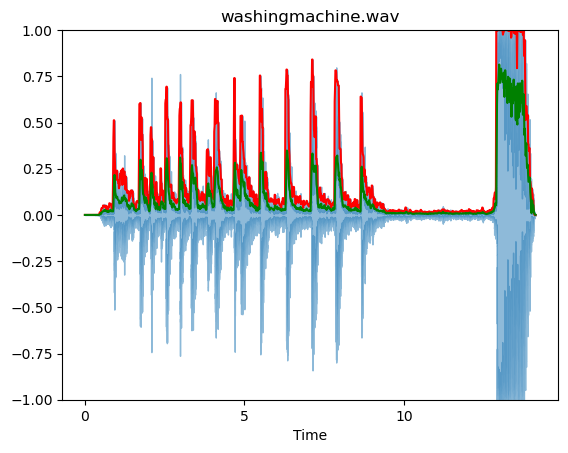

In [4]:

test.plot_wav(view_rms=True, view_ae=True)


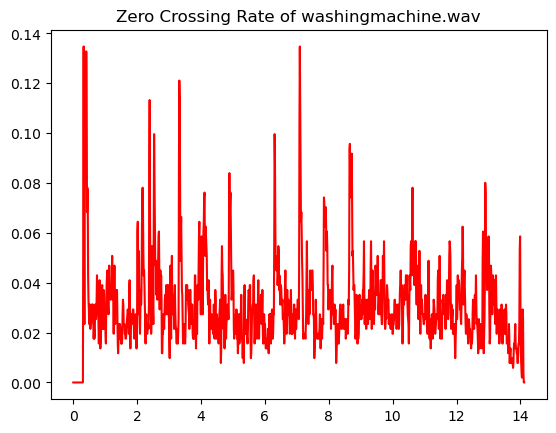

In [5]:
test.plot_zcr()

C:\Users\jmei7\AppData\Local\Temp\ipykernel_31464\433528774.py:124: RuntimeWarning: invalid value encountered in scalar divide
  BERs = np.array([np.sum(frame[:divider_bin])/np.sum(frame[divider_bin:]) for frame in power_spectrogram])


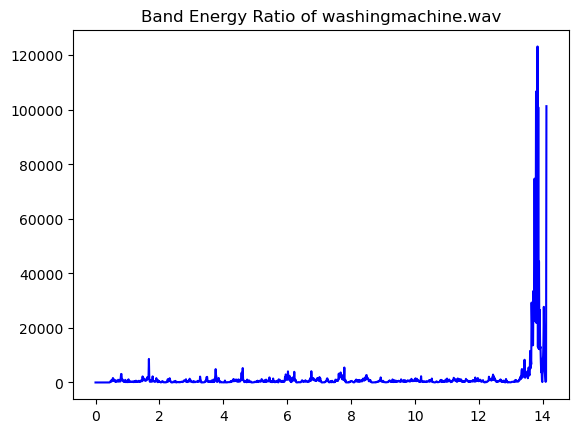

In [6]:
test.plot_BER(div_freq=5000)

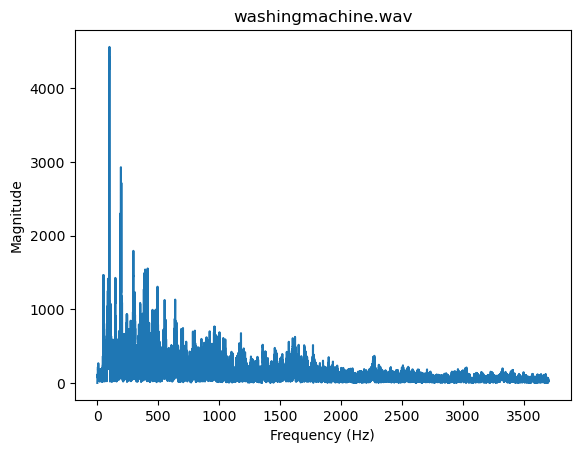

In [7]:
test.plot_fft_magspec()
#there is a lot of background noise in the clip, and it is evident here

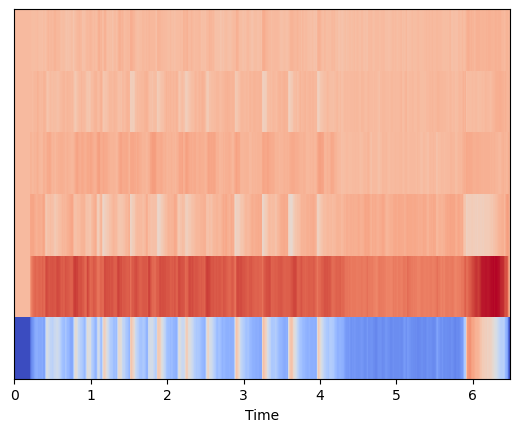

In [8]:
test.visualize_mfccs(6)

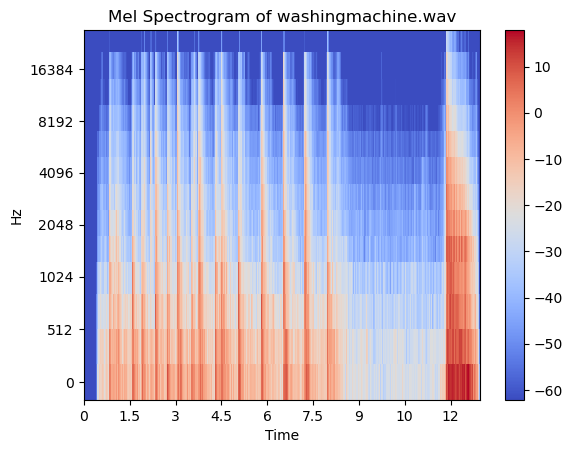

In [9]:
test.mel_spec(mel_bands=13)

<h3>Working with the Percussion Samples</h3>

In [10]:
#EXTRACT DATA FROM ZIP
file = 'Dataset.zip'
with ZipFile(file, 'r') as f: 
    f.printdir()
    f.extractall()
    

File Name                                             Modified             Size
Dataset/Instruments/                           2023-04-16 23:41:24            0
Dataset/Instruments/Cymatics - 808 Mini - C.wav 2023-04-16 22:10:26       215036
Dataset/Instruments/Cymatics - Apex 808 - C.wav 2023-04-16 22:10:26       264644
Dataset/Instruments/Cymatics - BASS Burial - C.wav 2023-04-15 22:01:02      1091522
Dataset/Instruments/Cymatics - BASS Deep - C.wav 2023-04-15 22:01:02       281186
Dataset/Instruments/Cymatics - BASS Donk - C.wav 2023-04-15 22:01:00       300656
Dataset/Instruments/Cymatics - BASS Doom - C.wav 2023-04-15 22:01:02      1384496
Dataset/Instruments/Cymatics - BASS Flam - C.wav 2023-04-15 22:01:02       103400
Dataset/Instruments/Cymatics - BASS Kanye - C.wav 2023-04-15 22:01:00       314258
Dataset/Instruments/Cymatics - BASS Moog - C.wav 2023-04-15 22:01:00      1587644
Dataset/Instruments/Cymatics - Bass One Shot 51 - F#.wav 2023-04-16 16:16:42       317564
Dataset/Ins

In [11]:

#get the sound data for all the files in the dataset (there used to be more to the dataset, but I was running out of time)
directory = 'Dataset/OneshotPercussion'
sound_data = np.vstack([SignalData(os.path.join(directory, clip)).features_oneshot(n_coeffs=40) for clip in os.listdir(directory)])
print(sound_data)

C:\Users\jmei7\anaconda3\envs\ds\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1938
  warnings.warn(


[[ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ...  8.8208308e-03
  -2.1721488e-03  1.3770889e-02]
 [ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ...  1.4519714e-02
  -3.1160975e-02  6.0807617e-04]
 [ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ...  1.5867902e-02
  -1.2617373e-02 -3.5045168e-03]
 ...
 [ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ...  6.2353414e-02
   1.4314704e-02 -4.2612642e-02]
 [ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ... -7.0811301e-02
  -6.0704630e-02  4.1789968e-02]
 [ 3.4355445e+00  1.9368775e+00  1.2379555e+00 ...  1.2795415e-02
  -1.4591936e-02 -9.6476832e-03]]


In [12]:
#Scale the data so that no feature affects it more than another
scaler = StandardScaler()
scaler.fit
scaled_data = scaler.fit_transform(sound_data)
print(scaled_data)

[[ 0.          0.          0.         ...  0.27142707 -0.00803849
   0.49341184]
 [ 0.          0.          0.         ...  0.42946035 -0.824699
   0.10806452]
 [ 0.          0.          0.         ...  0.46684638 -0.30229676
  -0.01233351]
 ...
 [ 0.          0.          0.         ...  1.755916    0.45642185
  -1.1572417 ]
 [ 0.          0.          0.         ... -1.936817   -1.6569899
   1.3136832 ]
 [ 0.          0.          0.         ...  0.38164455 -0.35792327
  -0.19217752]]


In [13]:
#get the labels from the file name
classify = [clip.split('-') for clip in os.listdir(directory)]

instrument = [i[0] for i in classify]
genre = [i[1] for i in classify]
filename = [i[2] for i in classify]

In [21]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(sound_data, instrument, train_size=0.90, random_state=71)
X_test.shape

['KICK', 'RIDE', 'C_HIHAT', 'RIDE', 'O_HIHAT', 'CRASH', 'NOISE', 'PERC', 'PERC', 'PERC', 'PERC', 'PERC', 'PERC', 'RIDE', 'PERC', 'CLAP', 'PERC', 'PERC', 'O_HIHAT', 'CLAP', 'C_HIHAT', 'O_HIHAT', 'NOISE', 'CRASH', 'PERC', 'RIMSHOT', 'PERC', 'C_HIHAT', 'O_HIHAT', 'SNAP', 'IMPACT', 'SNAP', 'O_HIHAT', 'IMPACT', 'C_HIHAT', 'NOISE', 'RISER', 'NOISE', 'C_HIHAT', 'RIMSHOT', 'RIDE', 'CLAP', 'CLAP', 'IMPACT', 'O_HIHAT', 'O_HIHAT', 'PERC', 'PERC', 'NOISE', 'CRASH', 'SNARE', 'RISER', 'CRASH', 'NOISE', 'NOISE', 'RIDE', 'C_HIHAT', 'O_HIHAT', 'SNARE', 'RIDE', 'IMPACT', 'PERC', 'O_HIHAT', 'KICK', 'PERC', 'CLAP', 'PERC', 'NOISE', 'KICK', 'C_HIHAT', 'NOISE', 'PERC', 'NOISE', 'SNARE', 'NOISE', 'CLAP', 'CLAP', 'RISER', 'PERC', 'SNARE', 'RIDE', 'NOISE', 'C_HIHAT', 'CLAP', 'PERC', 'NOISE', 'RIMSHOT', 'SNARE', 'C_HIHAT', 'NOISE', 'CLAP', 'CLAP', 'RIMSHOT', 'SNAP', 'KICK', 'NOISE', 'RIDE', 'C_HIHAT', 'CRASH', 'PERC', 'O_HIHAT', 'O_HIHAT', 'RIDE', 'KICK', 'CLAP', 'RIDE', 'CLAP', 'PERC', 'NOISE', 'CLAP', 'PERC',

In [15]:
knn = KNeighborsClassifier(n_neighbors=10)

#Determine the accuracy of the model 
def get_accuracy(X_train, X_test, y_train, y_test):
    #train with KNN(10 neighbors)
    knn.fit(X=X_train, y=y_train)
    predicted = knn.predict(X=X_test)
    expected = y_test
    
    #Borrowed and repurposed code from iris_classifier.ipynb
    compare = list(zip(predicted,expected))
    wrong = [(p,e) for (p,e) in compare if p != e]
    return 1 - len(wrong)/X_test.shape[0]

#loads the data from a directory 
def load_data(directory):
    return np.vstack([SignalData(os.path.join(directory, clip)).features_oneshot(n_coeffs=40) for clip in os.listdir(directory)])


get_accuracy(X_train, X_test, y_train, y_test)


0.625

In [16]:
#Testing the "failed" features from earlier, and unsurprisingly, the accuracy score is significantly lower

sound_data2 = np.vstack([SignalData(os.path.join(directory, clip)).features_various() for clip in os.listdir(directory)])
scaled_data2 = scaler.fit_transform(sound_data2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(sound_data2, instrument, train_size=0.90, random_state=71)

#Predict Instrument
get_accuracy(X_train2, X_test2, y_train2, y_test2)

0.296875

In [17]:
#Accuracy in Predicting Genre instead of Instrument
X_trainG, X_testG, y_trainG, y_testG = train_test_split(sound_data, genre, train_size=0.90)
get_accuracy(X_trainG, X_testG, y_trainG, y_testG)

0.3125

<h3>Testing Unknown Samples</h3>
<p>To put the model to the test, I wanted to test out how beatbox sounds would be classified, so I fed in some unmastered samples I produced to see.</p>

In [18]:
#extract test samples
testfile = 'TestSample.zip'
with ZipFile(testfile, 'r') as f:
    f.printdir()
    f.extractall()


File Name                                             Modified             Size
TestSample/bbxsample1.wav                      2023-04-17 04:35:20      1247404
TestSample/bbxsample2.wav                      2023-04-17 04:50:40       705644
TestSample/bbxsample3.wav                      2023-04-17 04:50:54      3115060
TestSample/bbxsample4.wav                      2023-04-17 04:51:02      2254900
TestSample/bbxsample5.wav                      2023-04-17 04:51:14       821300
TestSample/bbxsample6.wav                      2023-04-17 04:51:38       529244
TestSample/bbxsample7.wav                      2023-04-17 04:52:24       705644


In [19]:
#Load data and train, predict instrument
bbx_test = load_data('TestSample')
X_train, X_test, y_train, y_test = train_test_split(sound_data, instrument)
knn.fit(X=X_train, y=y_train)
predicted = knn.predict(X=bbx_test)
predicted


array(['SNARE', 'PERC', 'IMPACT', 'PERC', 'PERC', 'PERC', 'PERC'],
      dtype='<U7')

<p>So the results weren't too accurate, but the general idea was right for most of it:  After running multiple tests it seems the only results that tends to stay consistent is the IMPACT, which I expected should've been classified as NOISE.  Perhaps it is also a problem with the dataset that miscellaneous percussion samples are all labeled PERC, making it extremely broad.  </p>

In [20]:
#predict genre
X_train, X_test, y_train, y_test = train_test_split(sound_data, genre)
knn.fit(X=X_train, y=y_train)
predicted = knn.predict(X=bbx_test)
predicted

array(['HIPHOP', 'LOFI', 'DUBSTEP', 'LOFI', 'LOFI', 'LOFI', 'LOFI'],
      dtype='<U10')

<p>A lot of the genres predicted ended up being Lofi-Hip Hop, which is unsurprising given that a lot of the percussion in that genre is filtered or muffled for a relaxing effect, and the samples were not given filters or EQs to make them sound clearer.  The third entry was consistently found to be dubstep, which makes sense as it contains a mixture of both high frequency and extreme low frequency sound sweeps.  The only sample that had an interesting result was the first one, labeled "TRAP" and even "HIP HOP" in some occasions.  I intentionally produced a kick sound that was found in a genre not on the list to see what would happen, and honestly expected it to be placed in either Future Bass or Dubstep.</p>

<h3>Conclusions and Moving Forward</h3>
<p>The MFCC's ended up working best for training the data with minimal noise, and allowed accuracy rates greater than 50%. The time-domain features proved to be the least useful in this case, and it was likely due to the duration of the original sample having a significant skew on them.  The other frequency-domain features I thought would be useful just added more noise in this particular model (and it may be due to my inexperience in working with them), and I would probably have to experiment with other models in the future (when I learn them).  Overall, though extremely time consuming (I'm late for submission at this point, even), I found this project extremely self-fulfilling and would work on it again sometime in the future, hopefully improving it to accommodate loops and entire songs and include confusion matrices and other stats (which I wasn't able to include in a timely manner this time around).</p>